In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import numpyro
from numpyro.infer import Predictive
import pandas as pd
import dill
import matplotlib.pyplot as plt
import os
import sys
import arviz as az
# Add ../code to PYTHON_PATH
sys.path.insert(0, "../code")
sys.path.insert(0, "..")
import bnns.model_configs
from datasets.ecg import ECGDataset

/home/rasmuslovstad/Programs/assignments/thesis/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
SAMPLE_PATH = "../samples/2025-04-04T15:46:14.237620"
SEED = 10

In [4]:
methods = [d for d in os.listdir(SAMPLE_PATH) if os.path.isdir(os.path.join(SAMPLE_PATH, d))]
dataset = ECGDataset()

def load_samples():
    methods = os.listdir(SAMPLE_PATH)
    samples = []
    for method in methods:
        path = os.path.join(SAMPLE_PATH, method, "ecg")
        if method == "SVI":
            splits = os.listdir(path)
            for split in splits:
                with open(os.path.join(path, split), "rb") as f:
                    svi_result = dill.load(f)
                model_name = "_".join(split.split(".")[0].split("_")[:-1])
                split_ind = split.split(".")[0].split("_")[-1]
                model = getattr(bnns.model_configs, model_name)
                params = svi_result["params"]
                guide = svi_result["guide"]
                predictive = Predictive(guide, params=params, num_samples=1)
                post_draws = predictive(jax.random.PRNGKey(SEED), None)
                samples.append({
                    "model": model,
                    "method": method,
                    "model": model_name,
                    "split": split_ind,
                    "post_draws": post_draws
                })
        if method == "HMC":
            splits = os.listdir(path)
            for split in splits:
                if ".nc" not in split:
                    continue
                inference_data = az.from_netcdf(os.path.join(path, split))
                model_name = "_".join(split.split(".")[0].split("_")[:-1])
                split_ind = split.split(".")[0].split("_")[-1]
                model = getattr(bnns.model_configs, model_name)

                post_draws = inference_data.to_dict()["posterior"]
                post_draws.pop("y_probs", None)
                samples.append({
                    "model": model,
                    "method": method,
                    "model": model_name,
                    "split": split_ind,
                    "post_draws": post_draws
                })
    return samples
samples = load_samples()

In [5]:
from numpyro.infer import log_likelihood
from sklearn.utils import resample

def evaluate(model, post_draws, X, y, batch_ndims, adjust=True):
    predictive = Predictive(model, post_draws, batch_ndims=batch_ndims)
    if adjust:
        prior_probs = dataset.train_label_distribution()
    else:
        prior_probs = None
    predictions = predictive(jax.random.PRNGKey(SEED), X, prior_probs=prior_probs)["y_probs"]

    y_pred = jnp.argmax(predictions, -1)[0]
    assert y.shape[-1] == y_pred.shape[-1], f"y_test shape: {y.shape}, y_pred shape: {y_pred.shape}"
    return y_pred

def batch_nll(model, post_draws, X, y, batch_ndims, adjust=True):
    batch_size = 5120
    n_batches = X.shape[0] // batch_size + 1
    nlls = []
    if adjust:
        prior_probs = dataset.train_label_distribution()
    else:
        prior_probs = None

    for i in range(n_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        nll = -log_likelihood(model, post_draws, X[start:end], y[start:end], prior_probs=prior_probs, batch_ndims=batch_ndims)["y"]
        nlls.append(nll)
    return jnp.mean(jnp.concat(nlls, axis=-1))


In [6]:

results = []
preds = []
for sample_dict in samples:
    model = getattr(bnns.model_configs, sample_dict["model"])
    post_draws = sample_dict["post_draws"]
    batch_ndims = 1 if sample_dict["method"] == "SVI" else 2

    split = dataset.splits[int(sample_dict["split"])]
    X = dataset.normalize_X(dataset.X, split)

    X_train = X[split["tr"]]
    y_train = dataset.y[split["tr"]]

    X_test = X[split["te"]]
    y_test = dataset.y[split["te"]]

    train_nll = batch_nll(model, post_draws, X_train, y_train, batch_ndims, adjust=False)
    test_nll = batch_nll(model, post_draws, X_test, y_test, batch_ndims, adjust=True)

    y_pred_train = evaluate(model, post_draws, X_train, y_train, batch_ndims, adjust=False)
    train_accuracy = (y_train == y_pred_train).mean()

    y_pred_test = evaluate(model, post_draws, X_test, y_test, batch_ndims, adjust=True)
    y_pred_test_unadjusted = evaluate(model, post_draws, X_test, y_test, batch_ndims, adjust=False)
    test_accuracy = (y_test == y_pred_test).mean()
    test_accuracy_unadjusted = (y_test == y_pred_test_unadjusted).mean()

    results.append({
        "method": sample_dict["method"],
        "model": sample_dict["model"],
        "split": sample_dict["split"],
        "train_nll": train_nll.mean(),
        "test_nll": test_nll.mean(),
        "train accuracy": f"{train_accuracy * 100 : .3f}%",
        "test accuracy": f"{test_accuracy * 100 : .3f}%",
        "test accuracy, udadjusted": f"{test_accuracy_unadjusted * 100 : .3f}%"
    })
    preds.append({
        "y_train": y_train,
        "y_pred_train": y_pred_train,
        "y_test": y_test,
        "y_pred_test": y_pred_test,
        "y_pred_test_unadjusted": y_pred_test_unadjusted,
    })
results = pd.DataFrame(results)
results
    

,method,model,split,train_nll,test_nll,train accuracy,test accuracy,"test accuracy, udadjusted"
0,HMC,ECG_Spectral_BNN_128,0,0.8471266,0.55412644,68.894%,82.616%,53.092%


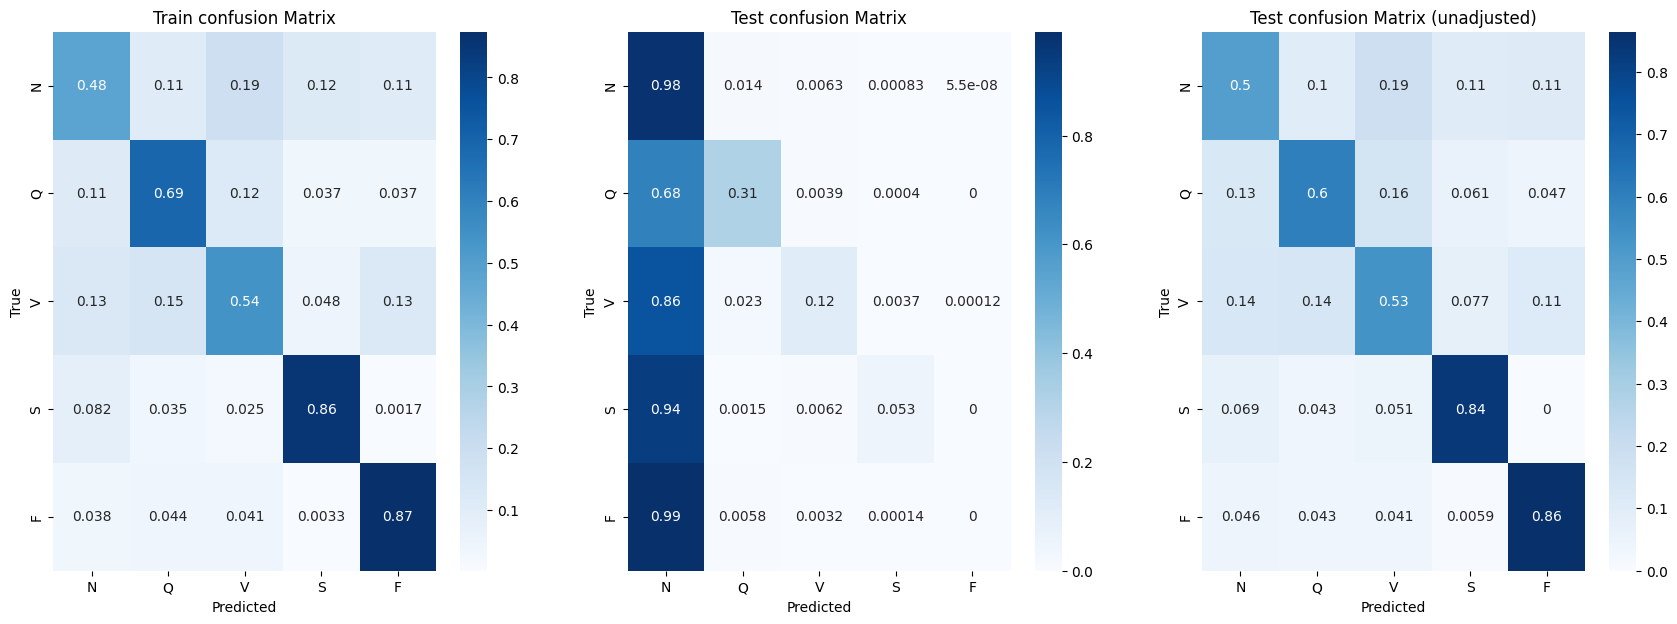

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

index = 0

train_y = preds[index]["y_train"]
y_pred_train = preds[index]["y_pred_train"].flatten()
train_y_repeated = jnp.tile(train_y, y_pred_train.shape[0] // train_y.shape[0])

test_y = preds[index]["y_test"]
y_pred_test = preds[index]["y_pred_test"].flatten()
test_y_repeated = jnp.tile(test_y, y_pred_test.shape[0] // test_y.shape[0])

y_pred_test_unadjusted = preds[index]["y_pred_test_unadjusted"].flatten()
test_y_repeated_unadjusted = jnp.tile(test_y, y_pred_test_unadjusted.shape[0] // test_y.shape[0])

# Generate confusion matrices
cm_train = confusion_matrix(train_y_repeated, y_pred_train, normalize='true')
cm_test = confusion_matrix(test_y_repeated, y_pred_test, normalize='true')
cm_test_unadjusted = confusion_matrix(test_y_repeated_unadjusted, y_pred_test_unadjusted, normalize='true')

# Plot confusion matrix
fig, axs = plt.subplots(ncols=3, figsize=(21, 7))
sns.heatmap(cm_train, ax=axs[0], annot=True, cmap='Blues', xticklabels=["N", "Q", "V", "S", "F"], yticklabels=["N", "Q", "V", "S", "F"])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Train confusion Matrix')
sns.heatmap(cm_test, ax=axs[1], annot=True, cmap='Blues', xticklabels=["N", "Q", "V", "S", "F"], yticklabels=["N", "Q", "V", "S", "F"])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Test confusion Matrix')
sns.heatmap(cm_test_unadjusted, ax=axs[2], annot=True, cmap='Blues', xticklabels=["N", "Q", "V", "S", "F"], yticklabels=["N", "Q", "V", "S", "F"])
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('True')
axs[2].set_title('Test confusion Matrix (unadjusted)')
plt.show()

In [8]:
preds[0]["y_pred_train"].flatten()

Array([3, 1, 2, ..., 2, 0, 0], dtype=int32)

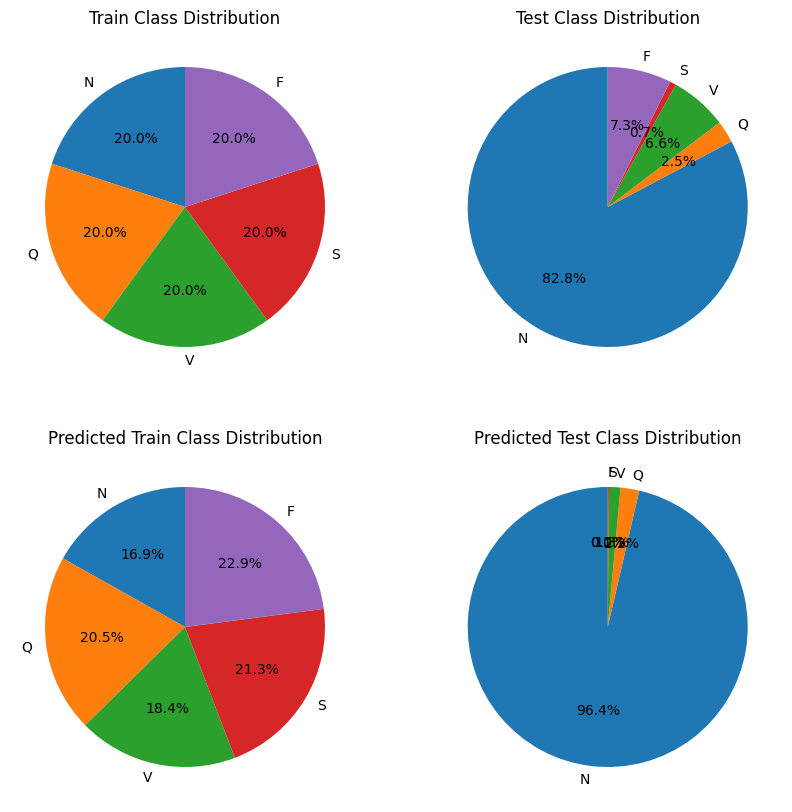

In [9]:
# Calculate class distribution
train_class_distribution = jnp.bincount(train_y.astype(int), minlength=5)
test_class_distribution = jnp.bincount(test_y.astype(int), minlength=5)

pred_train_class_distribution = jnp.bincount(y_pred_train.astype(int), minlength=5)
pred_test_class_distribution = jnp.bincount(y_pred_test.astype(int), minlength=5)

# Plot pie charts
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axs = axs.ravel()

axs[0].pie(train_class_distribution, labels=["N", "Q", "V", "S", "F"], autopct='%1.1f%%', startangle=90)
axs[0].set_title('Train Class Distribution')

axs[1].pie(test_class_distribution, labels=["N", "Q", "V", "S", "F"], autopct='%1.1f%%', startangle=90)
axs[1].set_title('Test Class Distribution')

axs[2].pie(pred_train_class_distribution, labels=["N", "Q", "V", "S", "F"], autopct='%1.1f%%', startangle=90)
axs[2].set_title('Predicted Train Class Distribution')

axs[3].pie(pred_test_class_distribution, labels=["N", "Q", "V", "S", "F"], autopct='%1.1f%%', startangle=90)
axs[3].set_title('Predicted Test Class Distribution')

plt.show()

In [87]:
predictive = Predictive(model, post_draws, batch_ndims=batch_ndims)
predictions = predictive(jax.random.PRNGKey(SEED), X_train)["y"]
predictions.shape

(1, 10000)

In [88]:
split["te"]

array([10000, 10001, 10002, ..., 31889, 31890, 31891], shape=(21892,))

In [89]:
X_train.shape

(10000, 187)

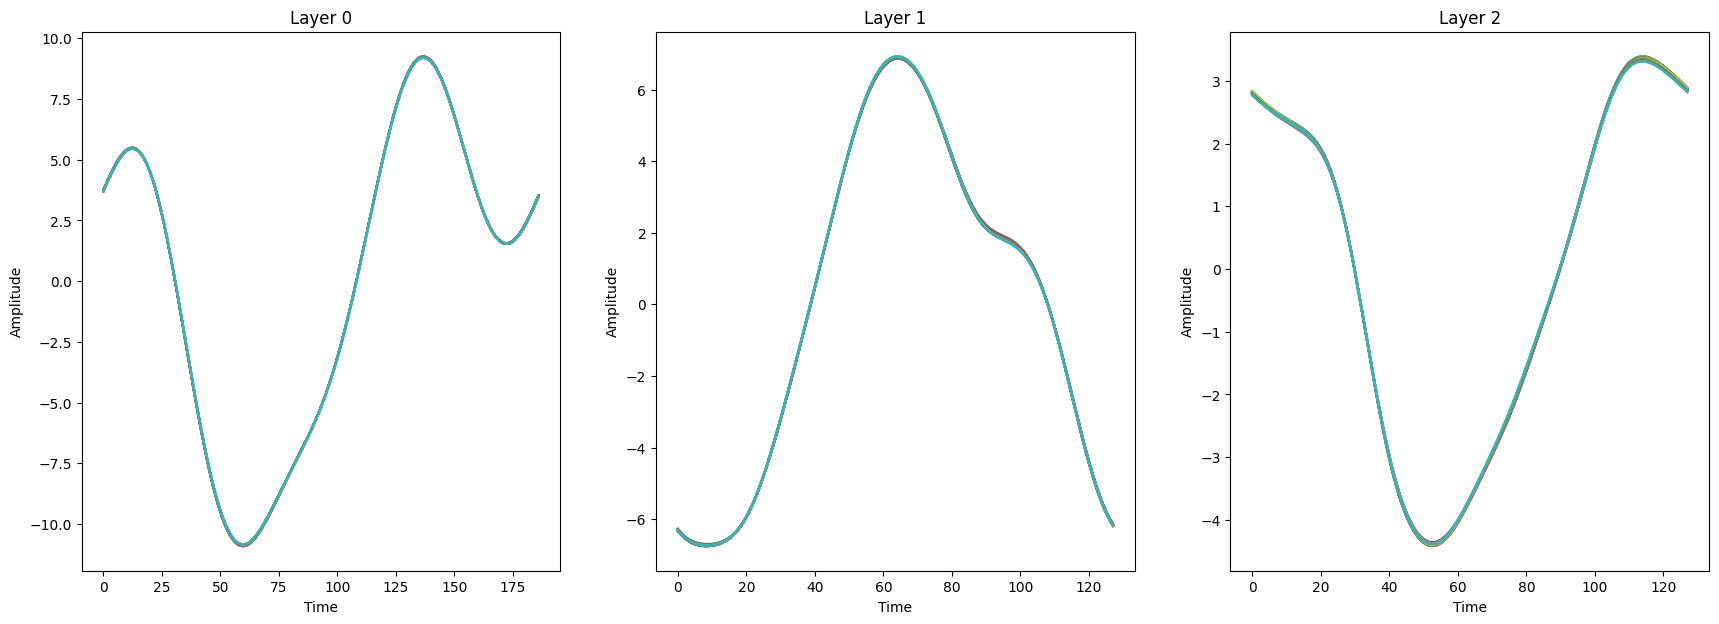

In [34]:
def is_hermitian(v):
    v2 = v[1:]
    res = v2 - v2[::-1].conj()
    return jnp.allclose(jnp.imag(res), 0, atol=1e-5) and jnp.allclose(jnp.real(res), 0, atol=1e-5)
def S(k, alpha=1e2, beta=1e5):
    return beta*jnp.exp(-(1/alpha) * k**2)
def sample_w_hat(normals, n: int, S=S, alpha=1e2, beta=1e5):
    w_hat = jnp.zeros(n, dtype=jnp.complex64)

    w_hat = w_hat.at[0].set(normals[0]) # w^ <- N(0, 1)
    for k in range(1, n//2):
        real = normals[2*k] * S(k, alpha=alpha, beta=beta) * 0.5
        img = normals[2*k+1] * S(k, alpha=alpha, beta=beta) * 0.5
        w_hat = w_hat.at[k].set(real + 1j * img)
        w_hat = w_hat.at[n-k].set(real - 1j * img)
    if n % 2 == 0:
        w_hat = w_hat.at[n//2].set(normals[n-1] * S(n//2))# Nyquist
    #assert is_hermitian(w_hat), "The generated vector is not hermitian"
    #assert jnp.allclose(jnp.imag(jnp.fft.ifft(w_hat)), 0, atol=1e-3)
    return w_hat

def get_kernel(normals, alpha=1e1, beta=1e2):
    w_hat = sample_w_hat(normals, normals.shape[0], alpha=1e1, beta=1e2)
    iffted = jnp.fft.ifft(w_hat)
    assert jnp.allclose(jnp.imag(iffted), 0, atol=1e-4), "The imaginary part of the inverse FFT is not zero."
    return jnp.real(iffted)

layers = 3
i = 0
normals = [samples[i]["post_draws"][f"w_hat_{layer}_normals"] for layer in range(layers)]
alpha = samples[i]["post_draws"]["alpha0"] if "alpha0" in samples[i]["post_draws"] else 1e1
beta = samples[i]["post_draws"]["beta0"] if "beta0" in samples[i]["post_draws"] else 1e2
fig, axs = plt.subplots(ncols=layers, figsize=(layers*7, 7))
if axs.ndim == 0:
    axs = [axs]
else:
    axs = axs.ravel()
for sample in range(850,900):
    for layer in range(layers):
        kernel = get_kernel(normals[layer][0][sample], alpha=alpha[0][sample][layer], beta=beta[0][sample][layer])
        axs[layer].plot(kernel)
        axs[layer].set_title(f"Layer {layer}")
        axs[layer].set_xlabel("Time")
        axs[layer].set_ylabel("Amplitude")

In [7]:
import jax.nn as nn
predictive = Predictive(model, post_draws, batch_ndims=batch_ndims)
prior_probs = dataset.train_label_distribution()
predictions = predictive(jax.random.PRNGKey(SEED), X[:10], prior_probs=prior_probs)["y_probs"]
nn.softmax(predictions)

Array([[[[0.26596734, 0.16138345, 0.16059314, 0.25284567, 0.15921044],
         [0.34019226, 0.18700756, 0.16133249, 0.15573002, 0.15573771],
         [0.3658633 , 0.15447126, 0.17249893, 0.1532771 , 0.15388939],
         ...,
         [0.25343445, 0.16243422, 0.2571639 , 0.15979286, 0.16717461],
         [0.26146814, 0.16173933, 0.16133547, 0.25613856, 0.15931848],
         [0.39621797, 0.15116276, 0.15242638, 0.15004349, 0.15014942]],

        [[0.2768856 , 0.16200486, 0.16057715, 0.24139404, 0.15913832],
         [0.3412826 , 0.18547277, 0.1619198 , 0.15565687, 0.1556679 ],
         [0.35925946, 0.15484305, 0.17736912, 0.15391877, 0.15460959],
         ...,
         [0.24716645, 0.1622531 , 0.261114  , 0.15991834, 0.16954805],
         [0.27020797, 0.1623738 , 0.16130736, 0.24679115, 0.15931968],
         [0.39566755, 0.15130633, 0.1526767 , 0.15010649, 0.15024294]],

        [[0.27333114, 0.16163763, 0.16048372, 0.2453951 , 0.15915245],
         [0.34286973, 0.1844314 , 0.1616514 ,

In [96]:
beta

Array([43.76822 , 67.91105 , 86.17925 , 98.000015], dtype=float32)